In [1]:
from clu import checkpoint

from tqdm import trange

import jax, flax
import numpy as np
import jax.numpy as jnp
import jax.random as jr

import transformer
from transformer import HollowTransformer

from matplotlib import pyplot as plt

key = jr.PRNGKey(0)

2024-09-25 00:06:36.280482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 00:06:36.324706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 00:06:36.338333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 00:06:38.065497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Configs

In [2]:
import ml_collections

class AbsorbingRate():
  def __init__(self, config):
    self.state_size = S = config.state_size
    self.scalar_rate = 1
    self.eps = config.rate_eps
    
    mask = S-1

    rate = np.zeros((S, S))
    rate[:-1, -1] = self.scalar_rate
    rate -= np.diag(jnp.sum(rate, axis=1))
    self.eigvals, self.eigvecs = jnp.linalg.eigh(rate)
    self.eigvals, self.eigvecs = np.linalg.eig(rate)
    self.inv_eigvecs = np.linalg.inv(self.eigvecs)
        
    self.base_rate = jnp.array(rate, dtype=np.float32)
#       self.rate_matrix = self.base_rate
    self.eigvals = jnp.array(self.eigvals, dtype=np.float32)
    self.eigvecs = jnp.array(self.eigvecs, dtype=np.float32)
    self.inv_eigvecs = jnp.array(self.inv_eigvecs, dtype=np.float32)
        
  def target_logits(self):
    S = self.state_size
    logits = - jnp.ones((S,)) * 10000
    return logits.at[-1].set(0)
      
  def _integral_rate_scalar(self, t):
    return -jnp.log1p(-(1 - self.eps) * t)
  
  def _rate_scalar(self, t):
    return (1 - self.eps) / (1 - (1 - self.eps) * t)
      
  def rate(self, t):
    return self._rate_scalar(t) * self.base_rate

  def transition(self, t, t0 = 0):
    S = self.state_size
    integral_rate_scalar = self._integral_rate_scalar(t+t0) - self._integral_rate_scalar(t0)
    adj_eigvals = integral_rate_scalar * self.eigvals
    trans = jnp.einsum("ij,jk,kl->il", self.eigvecs, jnp.diag(jnp.exp(adj_eigvals)), self.inv_eigvecs, 
                       precision=jax.lax.Precision.HIGHEST)
    trans = jnp.clip(trans, 0., 1.)
    return trans

def d(**kwargs):
  """Helper of creating a config dict."""
  return ml_collections.ConfigDict(initial_dictionary=kwargs)


def get_config():
  """Get the hyperparameters for the model"""
  config = ml_collections.ConfigDict()
  config.exp_name = "exp_vdm"
  config.model_type = "model_transformer"
  # config.ckpt_restore_dir = 'None'
  config.ckpt_restore_dir = 'gs://maskdiff/hollow/240918/checkpoints-0'

  config.use_hollow_transformer = True

  config.data = d(
      dataset='tokenized_imagenet_256',  # cifar10/cifar10_aug/cifar10_aug_with_channel
      ignore_cache=False,
      seq_length=256,
  )

  config.model = d(
    # tpu-v3 has less memory, use smaller network?
    vocab_size=1024 + 1, # Caveat: conditional generation stuff
    hidden_size=768 // 2,
    num_hidden_layers=24, # 24
    num_attention_heads=16 // 2,
    intermediate_size=3072 // 3 * 2,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1, # Same as hidden dropout prob
    max_position_embeddings=256, # seq length, since we are doing unconditional generation
    num_layers_per_mixed=6,

    # time conditioning
    # time_embedding_size=64,
    # time_scale_factor=1000,
    # mask_token_id = -1,
  )

  config.sampler = d(
    seed=42,
    num_steps=10, 
    max_samples=10_000,
    output_file_name="fb_samples_10k",
    corrector="forward_backward",
    corrector_step_size=1.,
  )

  config.noise = d(
    state_size=1024 + 1,
    rate_eps=1e-3
  )

  config.training = d(

      min_t=0.01,
      max_t=1.,
      eps=1e-6,
      nll_weight=.01,

      seed=1,
      substeps=1,
      num_steps_lr_warmup=100,
      num_steps_train=500_000, #100_000_000,
      num_steps_eval=100,
      batch_size_train=768 * 2, #1024 in paper version
      batch_size_eval=1024,
      steps_per_logging=100,
      steps_per_eval=1_000,
      steps_per_save=10_000,
      profile=False,
  )

  config.optimizer = d(
      name='adamw',
      args=d(
          b1=0.9,
          b2=0.99,
          eps=1e-8,
          weight_decay=0.01,
      ),
      learning_rate=1e-4, #2e-4 in paper version
      lr_decay=False,
      ema_rate=0.9999,
  )

  config.vqvae = ml_collections.ConfigDict()
  config.vqvae.quantizer = "vq"
  config.vqvae.codebook_size = 1024

  config.vqvae.entropy_loss_ratio = 0.1
  config.vqvae.entropy_temperature = 0.01
  config.vqvae.entropy_loss_type = "softmax"
  config.vqvae.commitment_cost = 0.25

  config.vqvae.filters = 128
  config.vqvae.num_res_blocks = 2
  config.vqvae.channel_multipliers = [1, 1, 2, 2, 4]
  config.vqvae.embedding_dim = 256
  config.vqvae.conv_downsample = False
  config.vqvae.activation_fn = "swish"
  config.vqvae.norm_type = "GN"

  return config

## Loading checkpoint

In [3]:
checkpoint_dir = 'gs://maskdiff/hollow/240919/checkpoints-0'

ckpt = checkpoint.Checkpoint(checkpoint_dir)
state_dict = ckpt.restore_dict()
params = flax.core.FrozenDict(state_dict['ema_params'])
step = int(state_dict['step'])

In [4]:
config = get_config()
forward_process = AbsorbingRate(config.noise)
seq_len = config.model.max_position_embeddings
vocab_size = config.model.vocab_size
model = transformer.HollowTransformer(**config.model)

In [27]:
l = 5

key, _ = jr.split(key)
inputs = jr.categorical(logits=jnp.ones((vocab_size,)), shape=(1, seq_len), key=key)
out1 = model.apply({"params": params}, inputs, None, deterministic=True)
# Shift the token on the lth position
inputs = inputs.at[0, l].set((inputs[0, l] - 1) % vocab_size)
out2 = model.apply({"params": params}, inputs, None, True)
# Should be zeros!
print((out1 - out2)[0, l])

[0. 0. 0. ... 0. 0. 0.]


In [120]:
out1.shape

(1, 256, 1025)

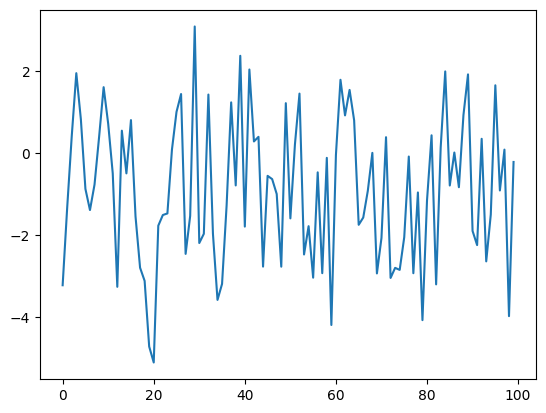

In [122]:
plt.plot(out1[0, 1, -100:])

## Sampling code

In [264]:
from jax.nn import softmax
from functools import partial

# TODO: we're using the non-batched version of the sampling code to test what the model has learned

def poisson_jump_reject(key, x, rates):
    D = x.shape[0]
    # S = rates.shape[1]
    # Mask out the self transitions
    rates = rates.at[jnp.arange(D), x].set(0.0)
    # (D, S)
    jump_nums = jr.poisson(key, rates)
    jump_target = jnp.argmax(jump_nums, axis=1)

    out = jnp.where((jnp.sum(jump_nums, axis=1) == 1), jump_target, x)
    return out

def poisson_jump_accept(key, x, rates):
    D = x.shape[0]
    # S = rates.shape[1]
    # Mask out the self transitions
    rates = rates.at[jnp.arange(D), x].set(0.0)
    # (D, S)
    jump_nums = jr.poisson(key, rates)
    jump_target = jnp.argmax(jump_nums, axis=1)

    out = jnp.where((jnp.sum(jump_nums, axis=1) >= 1), jump_target, x)
    return out

def euler_update(key, x, rates):
    D = x.shape[0]
    # Mask out the self transitions
    rates = rates.at[jnp.arange(D), x].set(0.0)
    sum_rates = jnp.sum(rates, axis=1)
    transition_logits = jnp.log1p(-jnp.exp(-rates)) # Prob = 1 - exp(-rate)
    transition_logits.at[jnp.arange(D), x].set(-sum_rates)

    out = jr.categorical(key, transition_logits).astype(jnp.int32)
    return out
    
def compute_backward(y, t, apply_fn, params, config, forward_process):
    y = y.flatten()
    D = y.shape[0]
    S = config.model.vocab_size
    # forward_process = config.forward_process
    min_t = config.training.min_t
    eps = config.training.eps
    qt0 = forward_process.transition(t)
    # R^d_t(*1,*2): (S, S) float array of instantenous transition rates
    # for a single dimension
    Rt = forward_process.rate(t)
    Rt_eval_y = Rt[:, y].T
    
    # TODO: we used squeeze to get rid of the batch dimension
    x0_logits = apply_fn({"params": params}, y[None], t, 
        deterministic=True).squeeze()
    # # Only take the valid parts of the output
    # x0_logits = x0_logits[...,:S-1]
    
    # p^{*1}_{0|t}(*2|y): (D, S) float array of marginal likelihoods for each dimension predicted by the model
    p0t_eval_y = softmax(x0_logits, axis=-1)
    # Manually append a 0 column, since it corresponds to the mask token
    # p0t_eval_y = jnp.concatenate((p0t_eval_y, jnp.zeros((D, 1))), axis=1)
    
    # q^{*1}_{t|0}(y^d|*2): (D, S) float array of transition probabilities to y
    qt0_eval_y = qt0[:,y].T + eps
    st_eval_y = jnp.einsum("0x,d0->dx", qt0, p0t_eval_y / qt0_eval_y, 
                           precision=jax.lax.Precision.HIGHEST)
    # (D, S) float array that masks out y[d] for each d index
    y_mask = jnp.ones((D, S))
    y_mask = y_mask.at[jnp.arange(D), y].set(0.0)

    # Change the score such that the score for the non-masked dimensions are inverted
    # This only works for absorbing (masking diffusion ofcourse)
    mask_token = S - 1
    backward_score_to_curr = st_eval_y[jnp.arange(D), y] + eps
    forward_score_from_curr = jnp.concatenate([jnp.zeros((D, S-1)), 1 / backward_score_to_curr[:, None]], axis=1)
    score = jnp.where((y != mask_token)[:,None], forward_score_from_curr, st_eval_y)
    
    results = {
        "score": score,
        "rates": (st_eval_y * Rt_eval_y) * y_mask,
        "x0_logits": x0_logits,
        "Rt_eval_y": Rt_eval_y,
        "Rt_eval_x": Rt[y]
    }
    return results
    
def backward_process_tau_leaping(apply_fn, params, ts, config, xT, key, forward_process):
    # Assuming 1D data
    D = config.data.seq_length
    S = config.model.vocab_size

    t = ts[0]
    x = xT
    
    poisson_jump = poisson_jump_reject

    def _step(carry, idx):
        x, key = carry
        t = ts[idx]
        dt = t - ts[idx+1]
        res = compute_backward(x, t, apply_fn, params, config, forward_process)
        backward_rates = res["rates"]
        x = poisson_jump(key, x, backward_rates * dt)
        key = jr.split(key)[0]
        return (x, key), x

    (x, _), x_hist = jax.lax.scan(_step, (xT, key), jnp.arange(len(ts)-1))
    res = compute_backward(x, t, apply_fn, params, config, forward_process)
    x0_logits = res["x0_logits"]

    x0_pred = jnp.argmax(x0_logits, axis=1)

    return x0_pred, x_hist

def mpf_corrector(res):
    coeff = res["Rt_eval_x"] + res["Rt_eval_y"]
    score = res["score"]
    return coeff * jnp.sqrt(score)

def barker_corrector(res):
    coeff = res["Rt_eval_x"] + res["Rt_eval_y"]
    score = res["score"]
    return coeff * score / (1 + score)

def forward_backward_corrector(res):
    return res["rates"] + res["Rt_eval_x"]

def backward_process_pc_tau_leaping(apply_fn, params, ts, config, xT, key, forward_process):
    """
    We assume that 1 corrector step is always used after each predictor step 
    """
    # Assuming 1D data
    D = config.data.seq_length
    S = config.model.vocab_size

    t = ts[0]
    x = xT
    
    poisson_jump = poisson_jump_accept

    corrector = config.sampler.corrector
    start = int(len(ts) * (1 - config.sampler.corrector_entry_time))
    
    if corrector == "barker":
        corrector_rate = barker_corrector
    elif corrector == "mpf":
        corrector_rate = mpf_corrector
    elif corrector == "forward_backward":
        corrector_rate = forward_backward_corrector
    else:
        raise Exception(f"Unknown corrector: {corrector}")

    corrector_step_size = config.sampler.corrector_step_size

    def _p_step(carry, idx):
        x, key = carry
        key, p_key, c_key = jr.split(key, 3)

        t = ts[idx]
        dt = t - ts[idx+1]
        res = compute_backward(x, t, apply_fn, params, config, forward_process)
        rp = res["rates"]
        x = poisson_jump(p_key, x, rp * dt)

        out = {
            "x": x,
            "rp": rp
        }
        
        return (x, key), out
    
    def _pc_step(carry, idx):
        x, key = carry
        key, p_key, c_key = jr.split(key, 3)

        t = ts[idx]
        dt = t - ts[idx+1]
        res = compute_backward(x, t, apply_fn, params, config, forward_process)
        rp = res["rates"]
        x = poisson_jump(p_key, x, rp * dt)
        
        # Corrector
        res = compute_backward(x, t, apply_fn, params, config, forward_process)
        rc = corrector_rate(res)
        x = poisson_jump(c_key, x, rc * dt * corrector_step_size)

        out = {
            "x": x,
            "rp": rp,
            "rc": rc
        }
        
        return (x, key), out

    t_ids = jnp.arange(len(ts)-1)
    (x, key), out_1 = jax.lax.scan(_p_step, (xT, key), t_ids[:start])
    (x, _), out_2 = jax.lax.scan(_pc_step, (x, key), t_ids[start:])
    # (x, _), out_2 = jax.lax.scan(_pc_step, (x, key), t_ids[start] * jnp.ones((200,), dtype=int))

    x_hist = {
        "x": jnp.concatenate([out_1["x"], out_2["x"]]),
        "rp": jnp.concatenate([out_1["rp"], out_2["rp"]]),
        "rc": out_2["rc"]
    }
    
    res = compute_backward(x, ts[-1], apply_fn, params, config, forward_process)
    x0_logits = res["x0_logits"]

    x0_pred = jnp.argmax(x0_logits, axis=1)

    return x0_pred, x_hist

In [331]:
def k_gillespies_update(key, x, rates, k=1, cutoff=None):
    eps = 1e-6
    key_exp, key_cat = jr.split(key)
    
    # Get holding times for each dimension
    D = x.shape[0]
    rates = rates.at[jnp.arange(D), x].set(eps)
            
    # Compute total rate (D,)
    rates_sum = jnp.sum(rates, axis=-1)
    # Sample a holding time (D,)
    taus = jr.exponential(key, shape=(D,)) / rates_sum
    # Find which locations each dimension would transition to conditioning on a transition
    jump_target = jr.categorical(key_cat, jnp.log(rates + eps)).astype(jnp.int32)
    
    taus_sorted = jnp.sort(taus, axis=-1)
    # Obtains cut off threshold given the number of updates.
    cutoff = cutoff or taus_sorted[k] # jnp.take_along_axis(taus, k, axis=-1)

    # TODO: add safety that prevents updates if rates_sum is lower than some threshold
    out = jnp.where((taus <= cutoff), jump_target, x)
    return out, cutoff

def backward_process_pc_k_gillespies(apply_fn, params, ts, config, xT, key, forward_process):
    """
    We assume that 1 corrector step is always used after each predictor step 
    """
    # Assuming 1D data
    D = config.data.seq_length
    S = config.model.vocab_size
    corrector = config.sampler.corrector
    k = config.sampler.k
    corrector_entry_time = config.sampler.corrector_entry_time
    corrector_cutoff = config.sampler.corrector_step_cutoff
    
    t = ts[0]
    x = xT

    poisson_jump = poisson_jump_accept
    
    if corrector == "barker":
        corrector_rate = barker_corrector
    elif corrector == "mpf":
        corrector_rate = mpf_corrector
    elif corrector == "forward_backward":
        corrector_rate = forward_backward_corrector
    else:
        raise Exception(f"Unknown corrector: {corrector}")

    def _corrector_entry_cond(state):
        _, x, _, _ = state
        no_corrector = (jnp.sum(x == (S-1)) / D) > corrector_entry_time
        return no_corrector
    
    def _end_cond(state):
        key, x, t, i = state
        not_at_end = t > ts[-1]
        return not_at_end

    def _p_step(state):
        key, x, t, nfe = state
        key, p_key, c_key = jr.split(key, 3)

        res = compute_backward(x, t, apply_fn, params, config, forward_process)
        rp = res["rates"]
        x, dt = k_gillespies_update(p_key, x, rp, k=k)

        t -= dt 
        
        return (key, x, t, nfe+1)
    
    def _pc_step(state):
        key, x, t, nfe = state
        key, p_key, c_key = jr.split(key, 3)

        res = compute_backward(x, t, apply_fn, params, config, forward_process)
        rp = res["rates"]
        x, dt = k_gillespies_update(p_key, x, rp, k=k)

        t -= dt 
        
        # Corrector
        res = compute_backward(x, t, apply_fn, params, config, forward_process)
        rc = corrector_rate(res)
        # x = poisson_jump(c_key, x, rc * dt * corrector_step_size)
        x, _ = k_gillespies_update(c_key, x, rc, cutoff=corrector_cutoff)

        return (key, x, t, nfe+2)
        
        # out = {
        #     "x": x,
        #     "rp": rp,
        #     "rc": rc,
        #     "t": t
        # }
        
        # return (x, key), out

    # t_ids = jnp.arange(len(ts)-1)
    # (x, key), out_1 = jax.lax.scan(_p_step, (xT, key), t_ids[:start])
    # (x, _), out_2 = jax.lax.scan(_pc_step, (x, key), t_ids[start:])

    key, x, t, nfe = jax.lax.while_loop(_corrector_entry_cond, _p_step, (key, xT, t, 0))
    _, x, t, nfe = jax.lax.while_loop(_end_cond, _pc_step, (key, x, t, nfe))
    
    x_hist = {
    #     "x": jnp.concatenate([out_1["x"], out_2["x"]]),
    #     "rp": jnp.concatenate([out_1["rp"], out_2["rp"]]),
    #     "rc": out_2["rc"]
        "t": t,
        "nfe": nfe,
        "mask_count": jnp.sum(x == (S-1))
    }

    res = compute_backward(x, ts[-1], apply_fn, params, config, forward_process)
    x0_logits = res["x0_logits"]

    x0_pred = jnp.argmax(x0_logits, axis=1)

    return x0_pred, x_hist

In [ ]:
key, _ = jr.split(key)

S = config.model.vocab_size
D = config.data.seq_length
min_t = config.training.min_t
max_t = config.training.max_t
num_steps = 100 #config.sampler.num_steps

config.sampler.k = 2

# sample_func = backward_process_pc_tau_leaping
sample_func = backward_process_pc_k_gillespies

config.sampler.corrector_entry_time = .6

# Initialize the all-mask state
xT = jnp.ones((D,), dtype=int) * (S - 1)

ts = jnp.linspace(max_t, min_t, num_steps)

# tokens, _ = backward_process(self.state.apply_fn, params, ts, config, xT, rng, 
#       self.forward_process)

config.sampler.corrector = "mpf"
config.sampler.corrector_step_size = .01
config.sampler.corrector_step_cutoff = 1 / 1000
# config.sampler.corrector = "barker"
# config.sampler.corrector_step_size = .1

p_sample_func = jax.pmap(partial(sample_func, apply_fn=model.apply, params=params, ts=ts, config=config, xT=xT, forward_process=forward_process))

tokens, hist = p_sample_func(key=jr.split(key, 8))

In [ ]:
hist

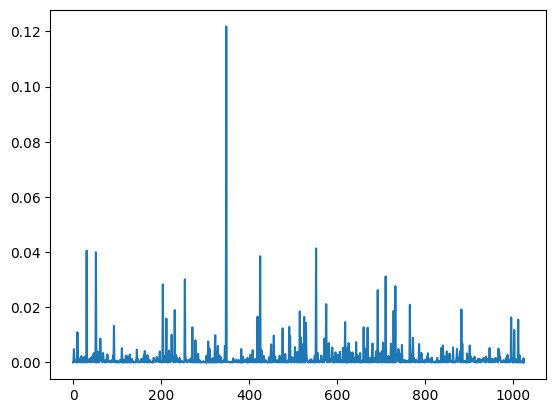

In [203]:
# Visualizing predictor rates
i = 0
step = 40
d = 44
plt.plot(hist["rp"][i,step][d])

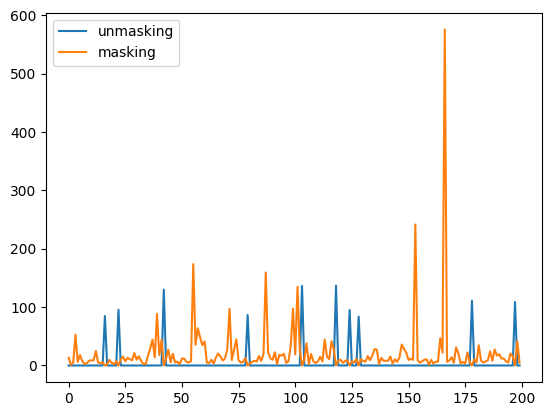

In [164]:
# Visualizing corrector rates
i = 0
step = 90
d = 200
plt.plot(np.sum(hist["rc"][i,step][:d, :-1], axis=-1), label="unmasking")
plt.plot(hist["rc"][i,step][:d,-1], label="masking")
plt.legend()
# plt.ylim((0, .1))

[250 252 250 252 246 248 251 249]/256 tokens are valid in the final step


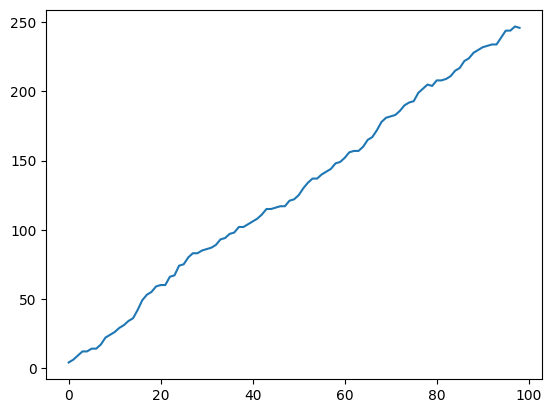

In [231]:
mask_curve = jnp.sum(hist["x"] != 1024, axis=-1)
plt.plot(mask_curve[4])
print(f'{mask_curve[:,-1]}/256 tokens are valid in the final step')

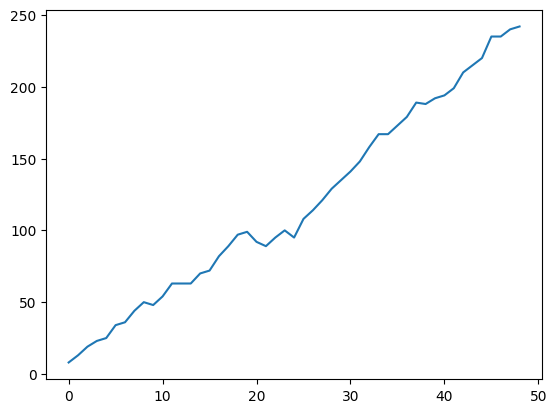

In [41]:
# This is the mask curve of the forward-backward corrector
mask_curve = jnp.sum(tokens_hist != 1024, axis=1)
plt.plot(mask_curve)

## Decode the tokens

In [55]:
from maskgit.nets import vqgan_tokenizer
import tensorflow.compat.v1 as tf
import flax

In [56]:
%cd ~/maskgit-jax

[Errno 2] No such file or directory: 'maskgit-jax'
/home/yixiuz/maskgit-jax


In [57]:
tokenizer_model = vqgan_tokenizer.VQVAE(config=config, dtype=jnp.float32, train=False)
tokenizer_path = "maskgit/checkpoints/tokenizer_imagenet256_checkpoint"
with tf.io.gfile.GFile(tokenizer_path, "rb") as f:
    tokenizer_params = flax.serialization.from_bytes(None, f.read())

In [ ]:
tokens = jnp.reshape(tokens, [-1, 16, 16])
images = tokenizer_model.apply(tokenizer_params, tokens,
          method=tokenizer_model.decode_from_indices,
          mutable=False)
id = 0

In [ ]:
id += 1
id %= 8
plt.imshow(images[id])